# Axis & Backbone

This notebook demonstrates the process of AP/DV Axis or Backbone models reconstruction based on 3D spatial transcriptome data. This is done in the following several steps:

1. Construct the point cloud, mesh and voxel models;
2. Calculate the AP and DV Axis of the drosophila embryo;
3. Calculate the Backbone of the drosophila amnioserosa;
4. Differential genes expression tests along the Axis/Backbone using generalized linear regressions.


In [1]:
import warnings

import numpy as np
from scipy.spatial import KDTree
from sklearn.decomposition import PCA
import spateo as st
warnings.filterwarnings('ignore')

2023-07-26 17:33:31.612387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the data

In [2]:
cpo = [(553, 1098, 277), (1.967, -6.90, -2.21), (0, 0, 1)]

adata = st.sample_data.drosophila(filename="E7-9h_cellbin.h5ad")
adata.uns["pp"] = {}
adata.uns["__type"] = "UMI"

amn_adata = st.sample_data.drosophila(filename="E7-9h_cellbin_amnioserosa.h5ad")
amn_adata.uns["pp"] = {}
amn_adata.uns["__type"] = "UMI"

adata, amn_adata

(AnnData object with n_obs × n_vars = 25921 × 8136
     obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
     uns: 'pp', '__type'
     obsm: '3d_align_spatial'
     layers: 'counts_X', 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 744 × 8136
     obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
     uns: '__type', 'pp'
     obsm: '3d_align_spatial'
     layers: 'counts_X', 'spliced', 'unspliced')

## Reconstruct the models (point cloud and mesh) corresponding to the drosophila embryo

See also [3D Reconstruction](./3D%20Reconstruction.ipynb) for more details on 3D reconstructed models.

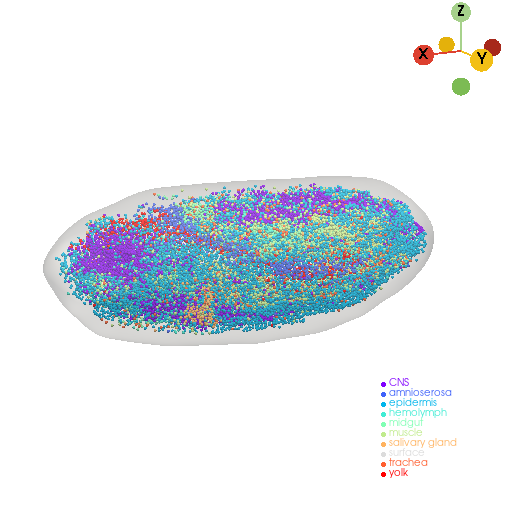

In [3]:
# Reconstruct point cloud model
pc, _ = st.tdr.construct_pc(adata=adata.copy(), spatial_key="3d_align_spatial", groupby="anno_tissue")
st.tdr.add_model_labels(model=pc, labels=["Point Cloud"]*pc.n_points, key_added="axis", where="point_data",inplace=True, alphamap=0.4, colormap="gainsboro")

# Reconstruct mesh model
mesh, _, _ = st.tdr.construct_surface(pc=pc, alpha=0.3, cs_method="marching_cube", cs_args={"mc_scale_factor": 1.8}, smooth=8000, scale_factor=1.0)
st.tdr.add_model_labels(model=mesh, labels=["Mesh"]*mesh.n_cells, key_added="axis", where="cell_data",inplace=True, alphamap=0.3, colormap="gainsboro")

# Visualization
st.pl.three_d_plot(model=st.tdr.collect_models([pc, mesh]), key="groups", model_style=["points", "surface"], jupyter="static", cpo=cpo)

## Calculate the AP and DV Axis of the drosophila embryo

In [4]:
pca = PCA(n_components=3)
pca_spatial = pca.fit_transform(np.asarray(adata.obsm["3d_align_spatial"])).astype(int)
adata.obs["ap_axis"] = pca_spatial[:, [0]]
adata.obs["dv_axis"] = pca_spatial[:, [2]]

In [5]:
empty_array = np.zeros(shape=[adata.shape[0], 1])
ap_line, _ = st.tdr.construct_axis_line(
    axis_points= np.c_[adata.obs["ap_axis"].values, empty_array, empty_array],
    key_added="axis",
    label="AP Axis",
    color="orangered",
)

dv_line, _ = st.tdr.construct_axis_line(
    axis_points= np.c_[empty_array, empty_array, adata.obs["dv_axis"].values],
    key_added="axis",
    label="DV Axis",
    color="skyblue",
)

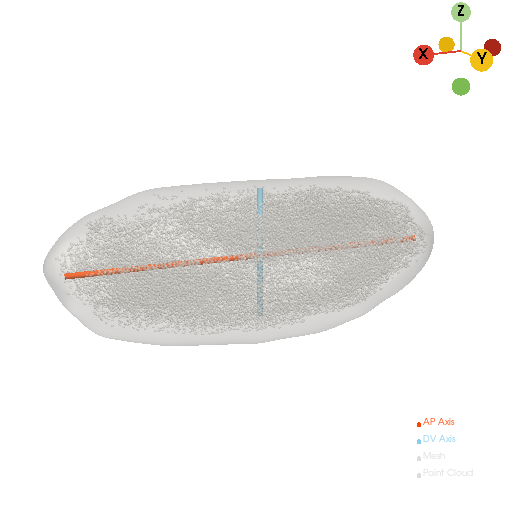

In [6]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([pc, mesh, ap_line, dv_line]), key="axis",
    model_style=["points", "surface", "wireframe", "wireframe"],
    model_size=[3, None, 6, 6], cpo=cpo, jupyter="static",
)

## Reconstruct the models (point cloud, mesh and voxel) corresponding to the drosophila amnioserosa

See also [3D Reconstruction](./3D%20Reconstruction.ipynb) for more details on 3D reconstructed models.

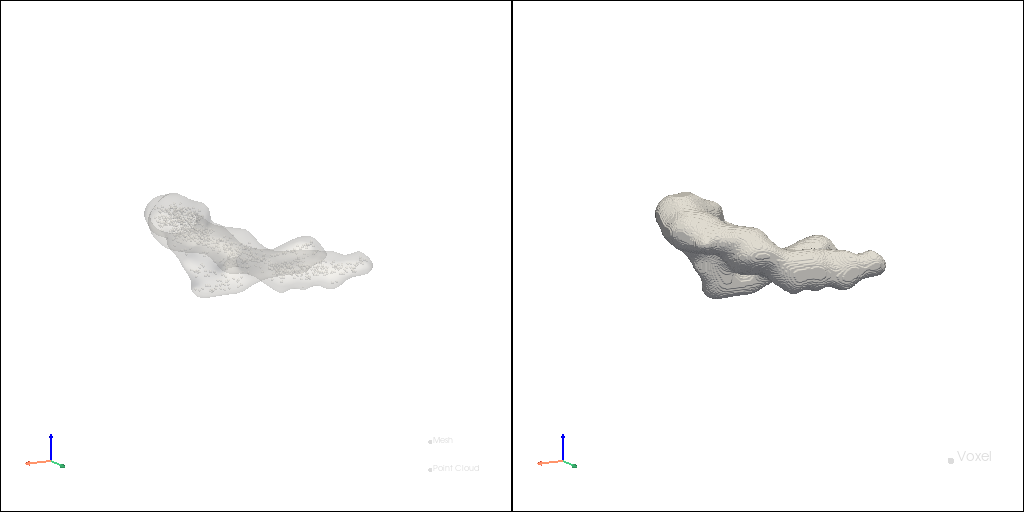

In [12]:
# Reconstruct point cloud model
amn_pc, _ = st.tdr.construct_pc(adata=amn_adata.copy(), spatial_key="3d_align_spatial", groupby="anno_tissue")
st.tdr.add_model_labels(model=amn_pc, labels=["Point Cloud"]*amn_pc.n_points, key_added="backbone", where="point_data",inplace=True, alphamap=0.4, colormap="gainsboro")

# Reconstruct mesh model
amn_mesh, _, _ = st.tdr.construct_surface(pc=amn_pc, alpha=0.3, cs_method="marching_cube", cs_args={"mc_scale_factor": 0.95}, smooth=4000, scale_factor=1.0)
st.tdr.add_model_labels(model=amn_mesh, labels=["Mesh"]*amn_mesh.n_cells, key_added="backbone", where="cell_data",inplace=True, alphamap=0.3, colormap="gainsboro")

# Reconstruct voxel model
amn_voxel, _ = st.tdr.voxelize_mesh(mesh=amn_mesh, voxel_pc=None, key_added="backbone", label="Voxel", color="gainsboro", smooth=300)

# Visualization
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models([st.tdr.collect_models([amn_pc, amn_mesh]), amn_voxel]), key="backbone",
    model_style=[["points", "surface"], "surface"], jupyter="static", cpo=[cpo], shape=(1, 2), ambient=[0.2, 0.1]
)

## Calculate the Backbone of drosophila CNS

2023-07-26 17:33:45.203385: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1062/1062 [==============================] - 0s 191us/step
|-----> [Running TRN] in progress: 100.0000%|-----> [Running TRN] completed [0.1421s]


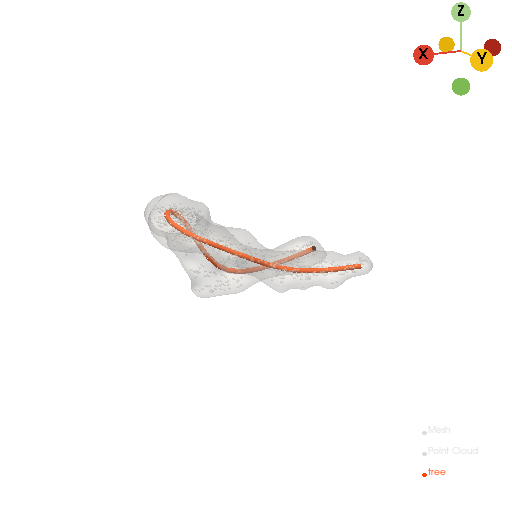

In [8]:
_, backbone, backbone_length, _ = st.tdr.changes_along_branch(
    model=amn_voxel,
    rd_method="PrinCurve",
    NumNodes=30,
    epochs=100,
    scale_factor=10,
    inplace=True,
    color="orangered",
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([amn_pc, amn_mesh, backbone]),
    key=["backbone", "backbone", "tree"],
    opacity=1,
    model_style=["points",  "surface", "wireframe"],
    model_size=[3, None, 5],
    show_legend=True,
    jupyter="static",
    cpo=cpo,
)

## Differential genes expression tests along the backbone using generalized linear regressions

In [9]:
backbone_nodes = np.asarray(backbone.points)
backbone_nodes_kdtree = KDTree(np.asarray(backbone_nodes))
_, ii = backbone_nodes_kdtree.query(np.asarray(amn_adata.obsm["3d_align_spatial"]), k=1)
amn_adata.obs["backbone"] = ii

In [13]:
st.tl.glm_degs(
    adata=amn_adata,
    fullModelFormulaStr=f'~cr(backbone, df=3)',
    key_added="glm_degs",
    qval_threshold=0.05,
    llf_threshold=-1000
)
print(amn_adata.uns["glm_degs"]["glm_result"])

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [96.1249s]
                 status family  log-likelihood          pval      qval
Obp99a               ok    NB2    -1616.447998  7.350401e-07  0.000035
pre-rRNA:CR45856     ok    NB2    -1800.844727  1.729476e-04  0.003722
bnb                  ok    NB2    -1047.054810  5.338198e-04  0.009202
CG12011              ok    NB2    -2302.088135  9.580593e-04  0.014172
RpL5                 ok    NB2    -1285.392212  2.089990e-03  0.025043


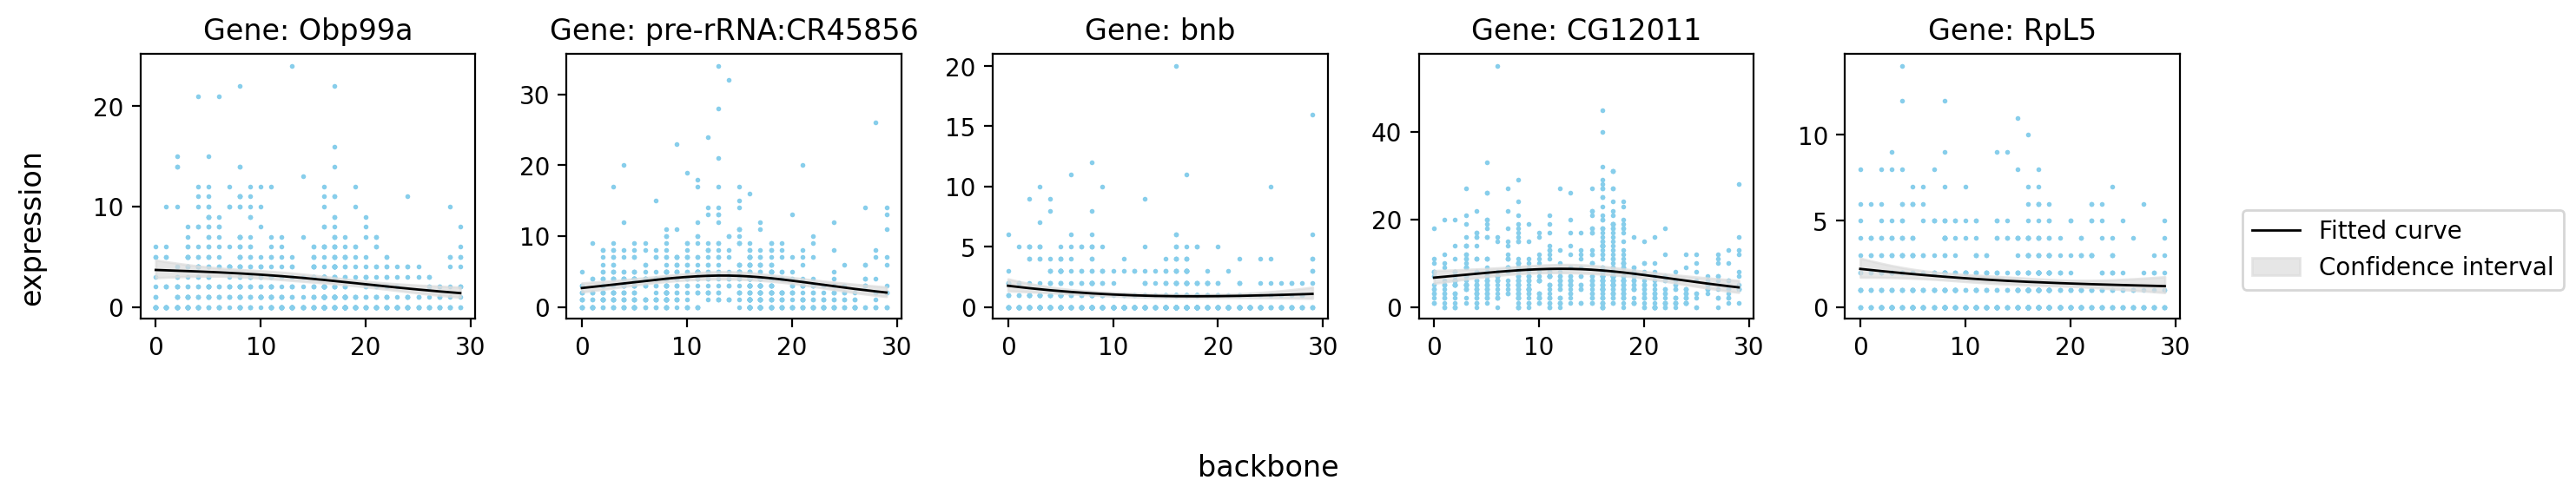

In [14]:
tissue_glm_data = amn_adata.uns["glm_degs"]["glm_result"]
st.pl.glm_fit(
    adata=amn_adata,
    gene=tissue_glm_data.index.tolist()[:5],
    ncols=5,
    feature_x="backbone",
    feature_y="expression",
    feature_fit="mu",
    glm_key="glm_degs",
    lowess=False,
    frac=0.2,
    save_show_or_return="show",
)